In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# set display options
%matplotlib inline
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

# set style and palette
sns.set_theme(style = 'dark')

In [2]:
# load dataset
df = pd.read_csv('food_deliveries.csv')

In [3]:
df.info(show_counts = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Dtype  
---  ------                                        -----  
 0   market_id                                     float64
 1   created_at                                    object 
 2   actual_delivery_time                          object 
 3   store_id                                      int64  
 4   store_primary_category                        object 
 5   order_protocol                                float64
 6   total_items                                   int64  
 7   subtotal                                      int64  
 8   num_distinct_items                            int64  
 9   min_item_price                                int64  
 10  max_item_price                                int64  
 11  total_onshift_dashers                         float64
 12  total_busy_dashers                            float64
 13 

In [4]:
# total missing values in each column
df.isna().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [5]:
# check for duplicates
print(df.duplicated().any())

False


In [6]:
# drop/ impute missing values
df = df[~df['market_id'].isna()]
df = df[~df['actual_delivery_time'].isna()]
df = df[~df['store_primary_category'].isna()]
df = df[~df['order_protocol'].isna()]
df = df[~df['estimated_store_to_consumer_driving_duration'].isna()]
df['total_onshift_dashers'] = df['total_onshift_dashers'].fillna(df['total_onshift_dashers'].median())
df['total_busy_dashers'] = df['total_busy_dashers'].fillna(df['total_busy_dashers'].median())
df['total_outstanding_orders'] = df['total_outstanding_orders'].fillna(df['total_outstanding_orders'].median())

In [7]:
# convert dtypes
df['market_id'] = df['market_id'].astype('int')
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['store_primary_category'] = df['store_primary_category'].astype('category')
df['order_protocol'] = df['order_protocol'].astype('int')
df['total_onshift_dashers'] = df['total_onshift_dashers'].astype('int')
df['total_busy_dashers'] = df['total_busy_dashers'].astype('int')
df['total_outstanding_orders'] = df['total_outstanding_orders'].astype('int')
df['estimated_order_place_duration'] = df['estimated_order_place_duration'].astype('float')

In [8]:
# create target variable
df['total_delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).apply(lambda x: x.total_seconds())

# extract order hour and drop timestamps
df['order_hour'] = df['created_at'].apply(lambda x: x.hour)
df = df.drop(columns = ['created_at', 'actual_delivery_time'])

# reorder rows
df = df[['market_id', 'store_id', 'store_primary_category', 'order_protocol', 'order_hour', 'total_items', 'num_distinct_items',
      'subtotal', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 
      'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'total_delivery_duration']]

In [9]:
df.describe()

,market_id,store_id,order_protocol,order_hour,total_items,num_distinct_items,subtotal,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration
count,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,1.914070e+05
mean,2.971824,3539.861855,2.897987,8.456091,3.193896,2.668591,2680.282409,685.731394,1158.522113,44.272038,41.301091,56.823131,307.497129,545.505922,2.908923e+03
std,1.523325,2051.340757,1.501752,8.656280,2.668956,1.628898,1822.578536,520.389771,557.252032,33.175196,30.884325,50.752027,89.592629,219.419825,1.952832e+04
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,1.010000e+02
25%,2.000000,1694.000000,1.000000,2.000000,2.000000,1.000000,1400.000000,299.000000,799.000000,19.000000,17.000000,19.000000,251.000000,382.000000,2.104000e+03
50%,3.000000,3600.000000,3.000000,3.000000,3.000000,2.000000,2200.000000,595.000000,1095.000000,37.000000,35.000000,41.000000,251.000000,544.000000,2.660000e+03
75%,4.000000,5302.000000,4.000000,19.000000,4.000000,3.000000,3394.000000,949.000000,1395.000000,62.000000,60.000000,80.000000,446.000000,702.000000,3.381000e+03
max,6.000000,6987.000000,7.000000,23.000000,411.000000,20.000000,27100.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,8.516859e+06


In [10]:
# drop rows where subtotal, min_item_price or max_item_price is less than zero
df = df[~((df['subtotal'] < 0) | (df['min_item_price'] < 0) | (df['max_item_price'] < 0))]

In [11]:
# drop rows where total_onshift_dashers, total_busy_dashers or total_outstanding_orders is less than zero
df = df[~((df['total_onshift_dashers'] < 0) | (df['total_busy_dashers'] < 0) | (df['total_outstanding_orders'] < 0))]

In [12]:
# detect outliers
vars = ['order_hour', 'total_items', 'num_distinct_items', 'subtotal', 'min_item_price', 'max_item_price', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'total_delivery_duration']
l = []

for var in vars:
    q1 = np.percentile(df[var], 25, method = 'midpoint')
    q3 = np.percentile(df[var], 75, method = 'midpoint')
    
    lower_bound = q1 - 1.5*(q3-q1)
    upper_bound = q3 + 1.5*(q3-q1)

    n_outliers = ((df[var] < lower_bound) | (df[var] > upper_bound)).sum()
    l.append([var, lower_bound, upper_bound, n_outliers])

df_outliers = pd.DataFrame(l, columns = ['variable', 'lower_bound', 'upper_bound', 'n_outliers'])
df_outliers

,variable,lower_bound,upper_bound,n_outliers
0,order_hour,-23.5,44.5,0
1,total_items,-1.0,7.0,9259
2,num_distinct_items,-2.0,6.0,5719
3,subtotal,-1591.0,6385.0,8759
4,min_item_price,-676.0,1924.0,4372
5,max_item_price,-95.0,2289.0,7468
6,estimated_order_place_duration,-41.5,738.5,26
7,estimated_store_to_consumer_driving_duration,-98.0,1182.0,358
8,total_delivery_duration,188.5,5296.5,6068


In [13]:
# remove outliers
for row in l:
    var = row[0]
    lower_bound = row[1]
    upper_bound = row[2]

    df = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]

In [14]:
# reset index after cleaning
df = df.reset_index(drop = True)

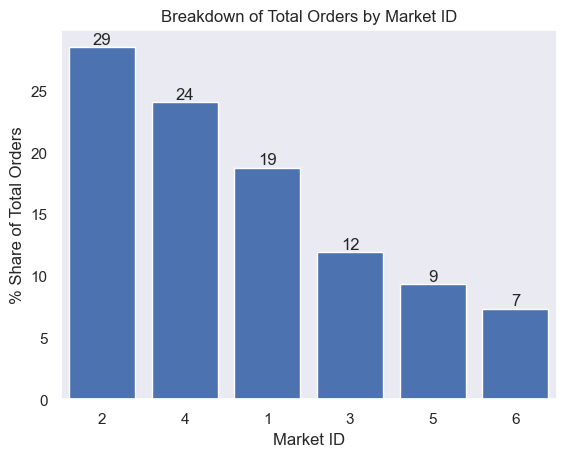

In [15]:
fig, ax = plt.subplots()
sns.countplot(x = df['market_id'], order = df['market_id'].value_counts().index, saturation = 1, stat = 'percent')
ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.0f')
ax.set_title('Breakdown of Total Orders by Market ID')
ax.set_xlabel('Market ID')
ax.set_ylabel('% Share of Total Orders')
plt.show()

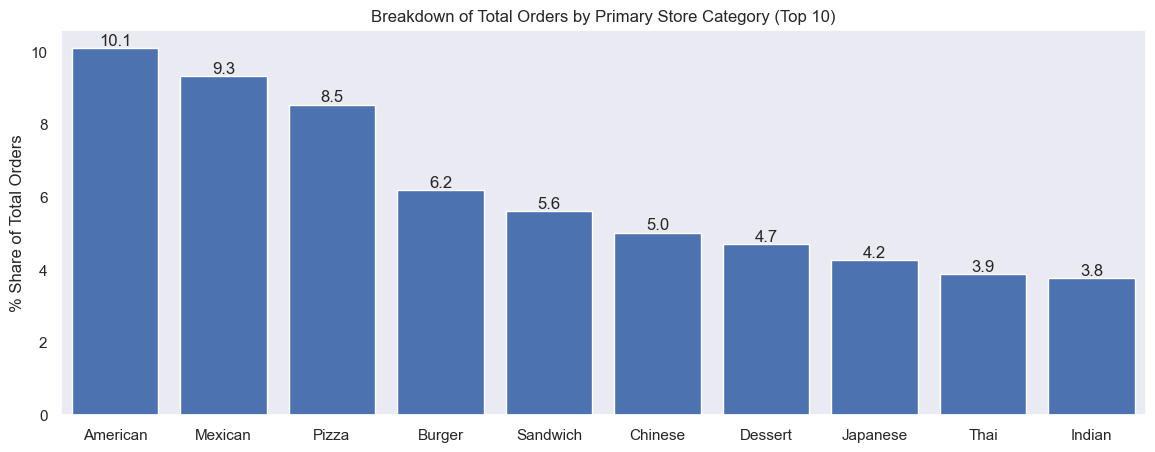

In [16]:
fig, ax = plt.subplots(figsize = (14, 5))
sns.countplot(x = df['store_primary_category'].str.title(), order = df['store_primary_category'].str.title().value_counts().index[:10], saturation = 1, stat = 'percent')
ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.1f')
ax.set_title('Breakdown of Total Orders by Primary Store Category (Top 10)')
ax.set_xlabel(None)
ax.set_ylabel('% Share of Total Orders')
plt.show()

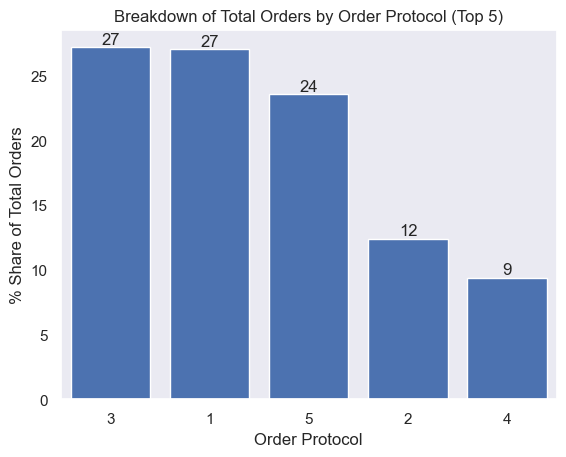

In [17]:
fig, ax = plt.subplots()
sns.countplot(x = df['order_protocol'], order = df['order_protocol'].value_counts().index[:5], saturation = 1, stat = 'percent')
ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.0f')
ax.set_title('Breakdown of Total Orders by Order Protocol (Top 5)')
ax.set_xlabel('Order Protocol')
ax.set_ylabel('% Share of Total Orders')
plt.show()

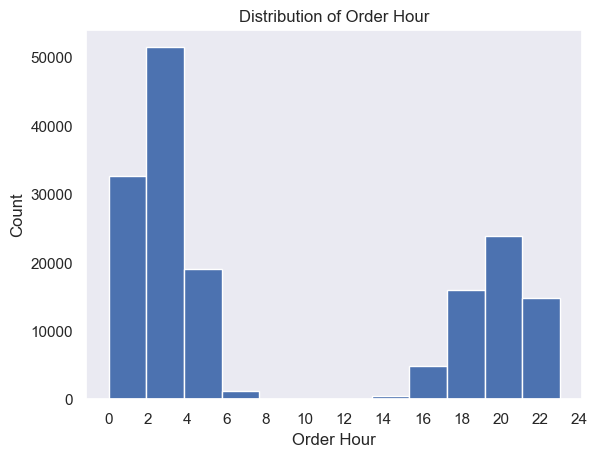

In [18]:
fig, ax = plt.subplots()
sns.histplot(x = df['order_hour'], alpha = 1, binwidth = 2)
ax.set_title('Distribution of Order Hour')
ax.set_xlabel('Order Hour')
ax.set_xticks(np.arange(0, 26, 2))
plt.show()

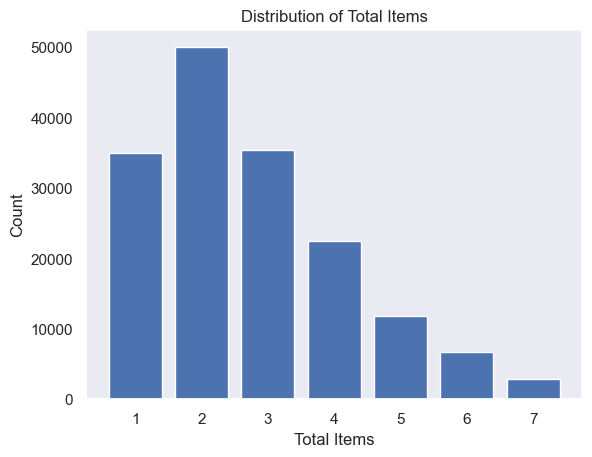

In [19]:
fig, ax = plt.subplots()
sns.histplot(x = df['total_items'], alpha = 1, discrete = True, shrink = 0.8)
ax.set_title('Distribution of Total Items')
ax.set_xlabel('Total Items')
plt.show()

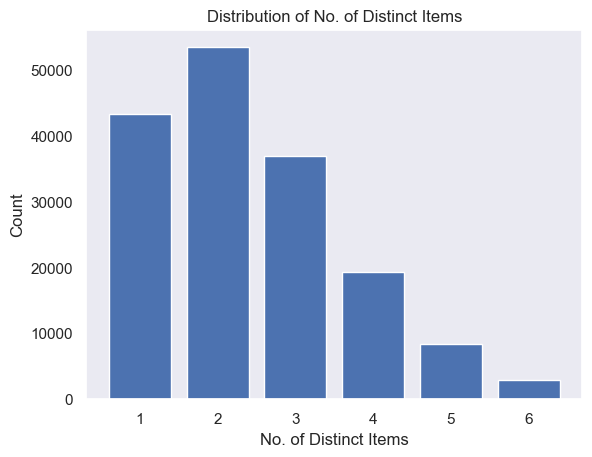

In [20]:
fig, ax = plt.subplots()
sns.histplot(x = df['num_distinct_items'], alpha = 1, discrete = True, shrink = 0.8)
ax.set_title('Distribution of No. of Distinct Items')
ax.set_xlabel('No. of Distinct Items')
plt.show()

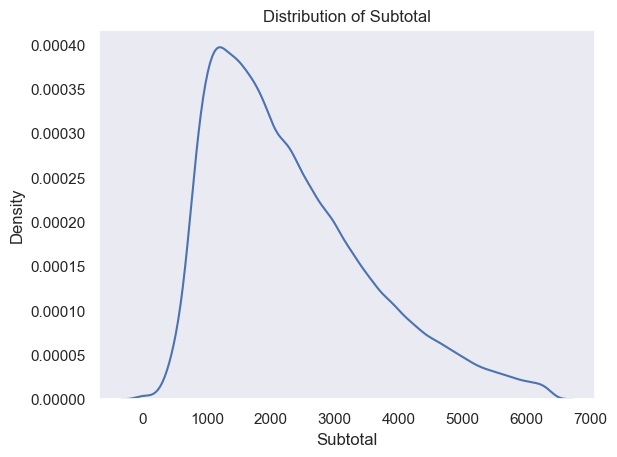

In [21]:
fig, ax = plt.subplots()
sns.kdeplot(x = df['subtotal'], alpha = 1)
ax.set_title('Distribution of Subtotal')
ax.set_xlabel('Subtotal')
plt.show()

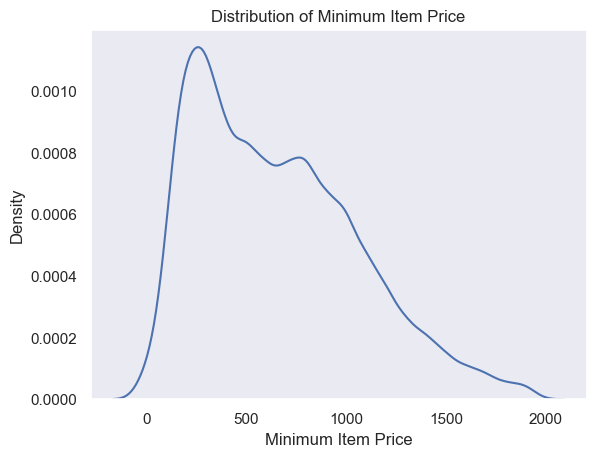

In [22]:
fig, ax = plt.subplots()
sns.kdeplot(x = df['min_item_price'], alpha = 1, bw_adjust = 1.5)
ax.set_title('Distribution of Minimum Item Price')
ax.set_xlabel('Minimum Item Price')
plt.show()

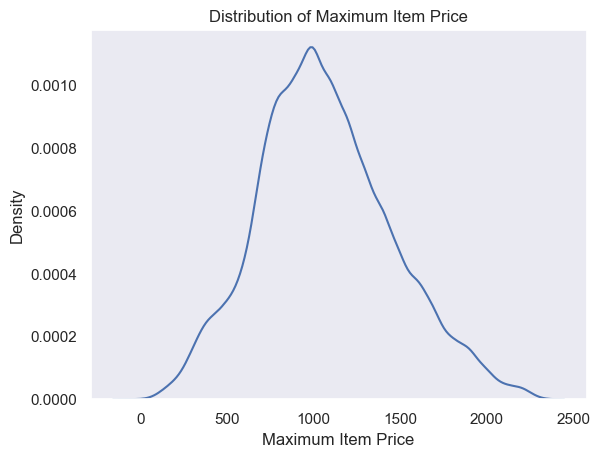

In [23]:
fig, ax = plt.subplots()
sns.kdeplot(x = df['max_item_price'], alpha = 1, bw_adjust = 1.5)
ax.set_title('Distribution of Maximum Item Price')
ax.set_xlabel('Maximum Item Price')
plt.show()

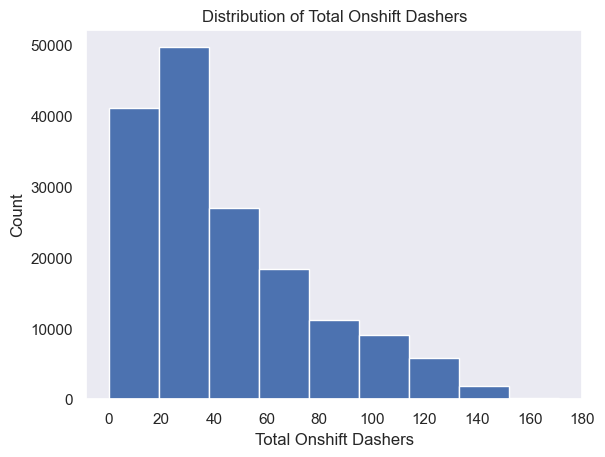

In [24]:
fig, ax = plt.subplots()
sns.histplot(x = df['total_onshift_dashers'], alpha = 1, binwidth = 20)
ax.set_title('Distribution of Total Onshift Dashers')
ax.set_xlabel('Total Onshift Dashers')
ax.set_xticks(np.arange(0, df['total_onshift_dashers'].max() + 20, 20))
plt.show()

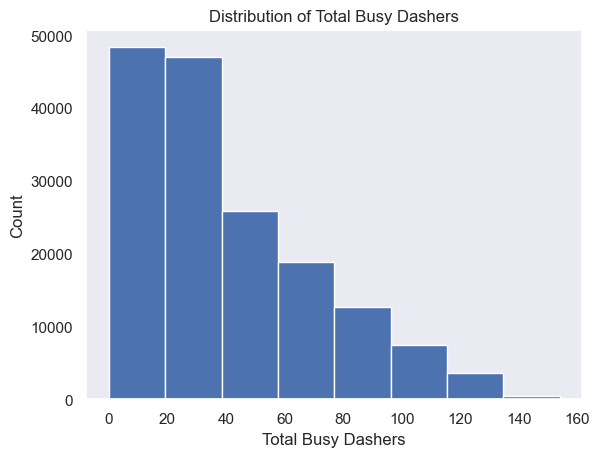

In [25]:
fig, ax = plt.subplots()
sns.histplot(x = df['total_busy_dashers'], alpha = 1, binwidth = 20)
ax.set_title('Distribution of Total Busy Dashers')
ax.set_xlabel('Total Busy Dashers')
ax.set_xticks(np.arange(0, df['total_busy_dashers'].max() + 20, 20))
plt.show()

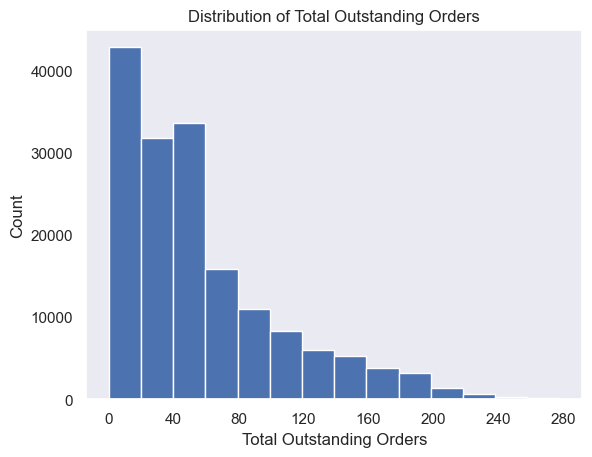

In [26]:
fig, ax = plt.subplots()
sns.histplot(x = df['total_outstanding_orders'], alpha = 1, binwidth = 20)
ax.set_title('Distribution of Total Outstanding Orders')
ax.set_xlabel('Total Outstanding Orders')
ax.set_xticks(np.arange(0, df['total_outstanding_orders'].max() + 40, 40))
plt.show()

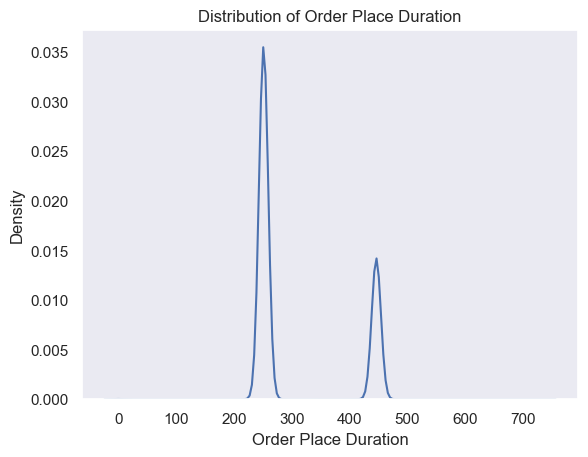

In [27]:
fig, ax = plt.subplots()
sns.kdeplot(x = df['estimated_order_place_duration'], alpha = 1)
ax.set_title('Distribution of Order Place Duration')
ax.set_xlabel('Order Place Duration')
plt.show()

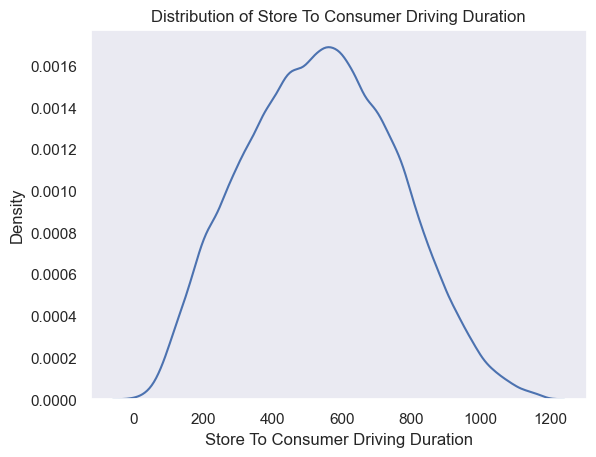

In [28]:
fig, ax = plt.subplots()
sns.kdeplot(x = df['estimated_store_to_consumer_driving_duration'], alpha = 1)
ax.set_title('Distribution of Store To Consumer Driving Duration')
ax.set_xlabel('Store To Consumer Driving Duration')
plt.show()

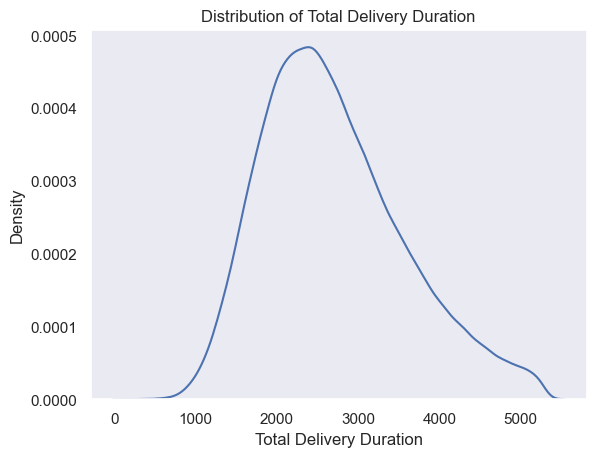

In [29]:
fig, ax = plt.subplots()
sns.kdeplot(x = df['total_delivery_duration'], alpha = 1)
ax.set_title('Distribution of Total Delivery Duration')
ax.set_xlabel('Total Delivery Duration')
plt.show()

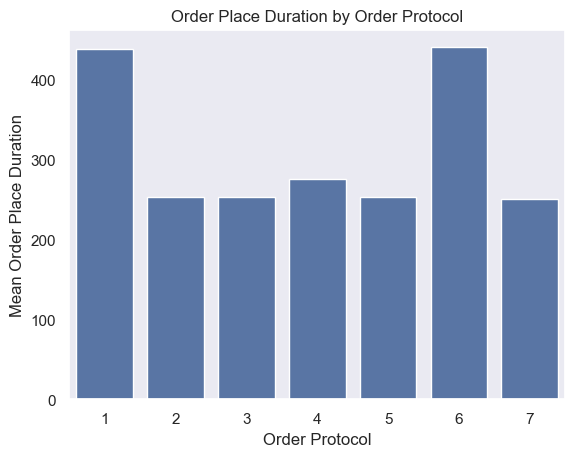

In [30]:
fig, ax = plt.subplots()
sns.barplot(x = df['order_protocol'], y = df['estimated_order_place_duration'], errorbar =  None)
ax.set_title('Order Place Duration by Order Protocol')
ax.set_xlabel('Order Protocol')
ax.set_ylabel('Mean Order Place Duration')
plt.show()

In [31]:
# feature engineering
df['non_prep_duration'] = df['estimated_order_place_duration'] + df['estimated_store_to_consumer_driving_duration']
df['total_available_dashers'] = df['total_onshift_dashers'] - df['total_busy_dashers']

df = df[['market_id', 'store_id', 'store_primary_category', 'order_protocol', 'order_hour', 'total_items', 'num_distinct_items', 'subtotal',
         'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_available_dashers',
         'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration',
         'non_prep_duration', 'total_delivery_duration']]

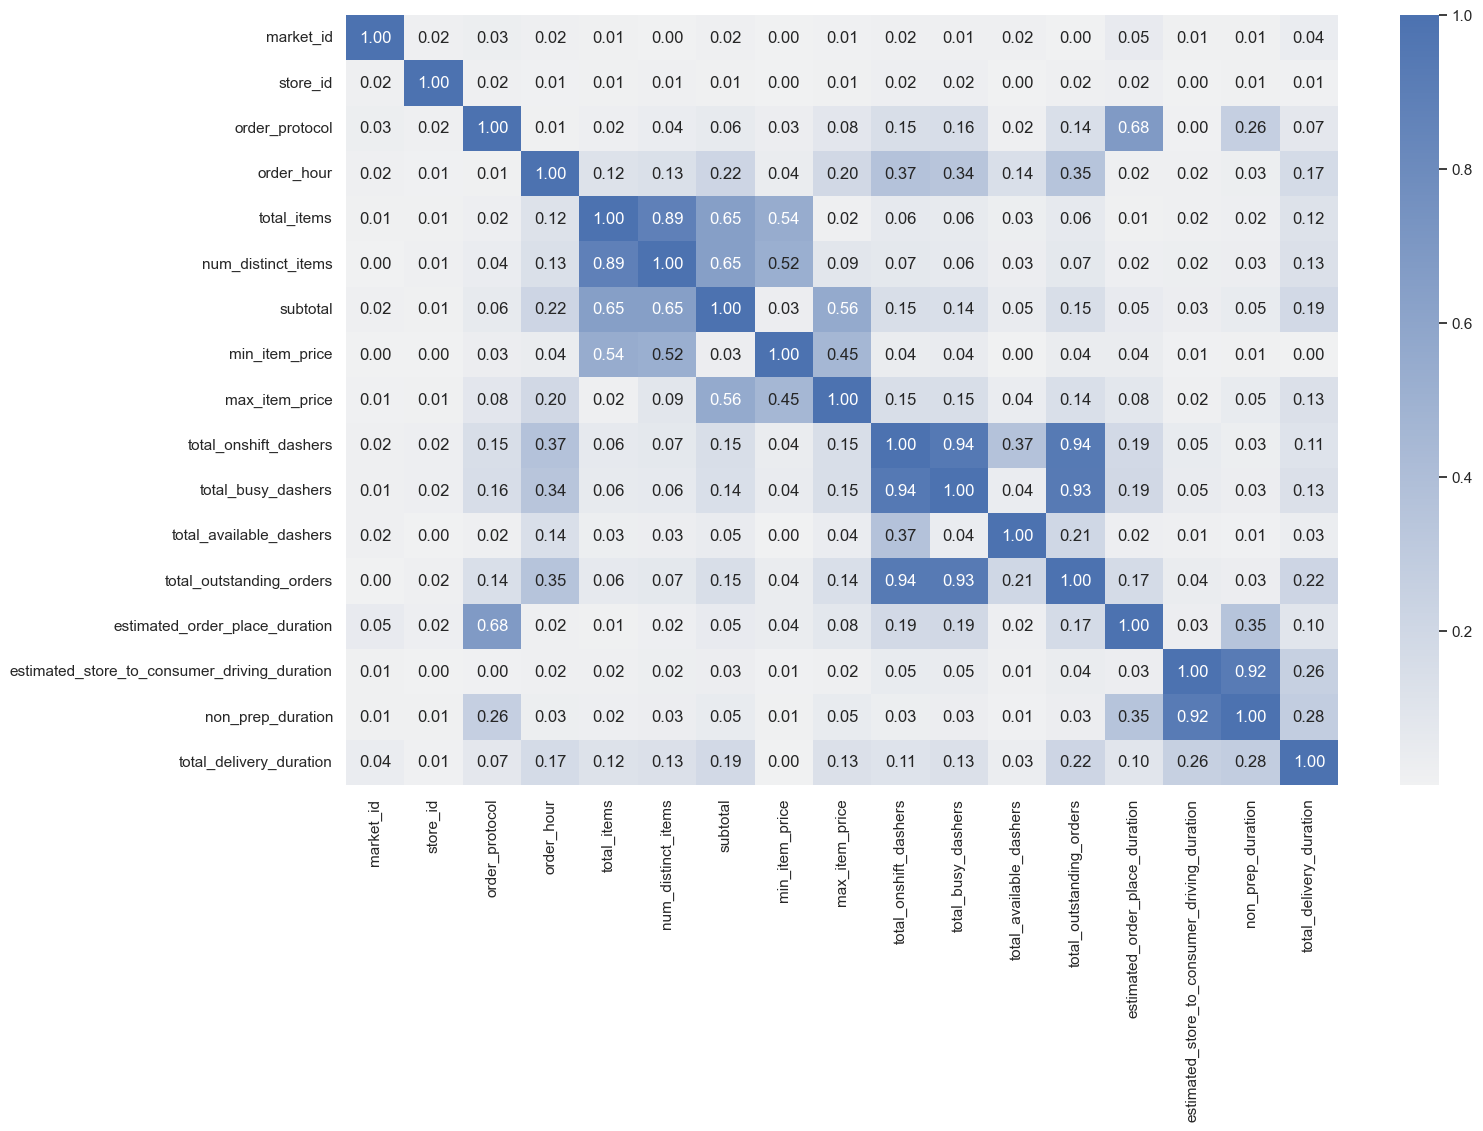

In [32]:
# correlation heatmap
base_color = sns.color_palette("deep")[0]
custom_colormap = sns.light_palette(base_color, as_cmap = True)

df_subset = df.drop(columns = 'store_primary_category')
correlations = abs(df_subset.corr())

fig, ax = plt.subplots(figsize = (16, 10))
sns.heatmap(correlations, annot = True, cmap = custom_colormap, fmt = '.2f')
plt.show()

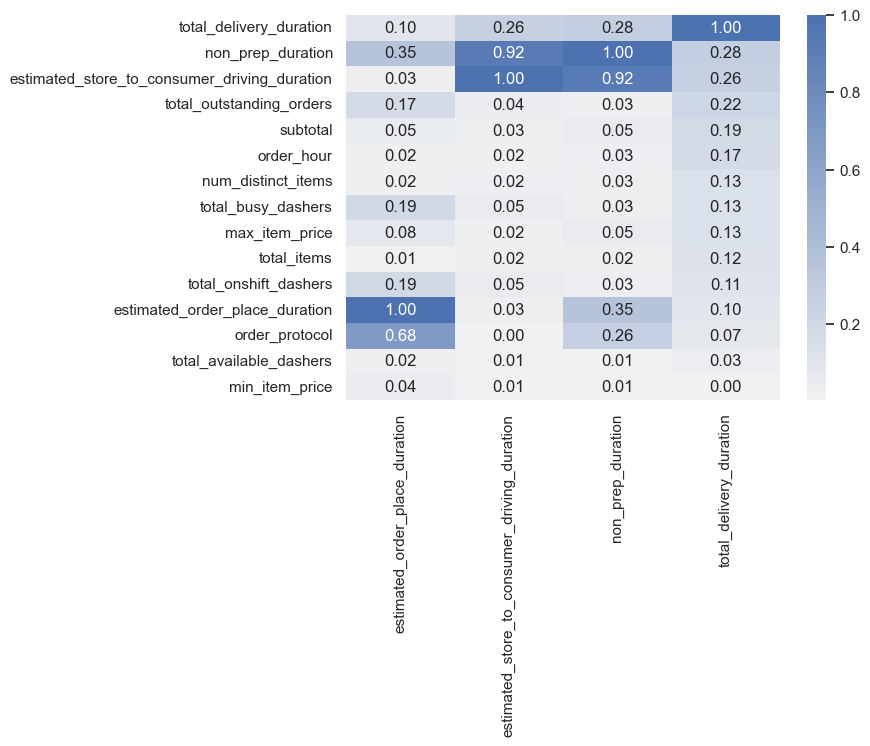

In [33]:
correlations2 = correlations.iloc[2:, -4:].sort_values(by = 'total_delivery_duration', ascending = False)

fig, ax = plt.subplots(figsize = (7, 5))
sns.heatmap(correlations2, annot = True, cmap = custom_colormap, fmt = '.2f')
plt.show()

In [34]:
# drop store_id
df.drop(columns = 'store_id', inplace = True)
 
# drop features due to multicollinearity
df.drop(columns = ['total_items', 'total_onshift_dashers', 'total_busy_dashers', 'estimated_store_to_consumer_driving_duration', 
                   'estimated_order_place_duration'], inplace = True)

# convert store_primary_category, market_id and order_protocol into dummy variables
df = pd.get_dummies(df, columns = ['store_primary_category', 'market_id', 'order_protocol'], drop_first = True)

In [35]:
# split data into training, validation and testing sets
X = df.drop(columns = 'total_delivery_duration')
y = df['total_delivery_duration']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2/ 0.8, random_state = 42)

In [36]:
# scale features
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

# find mse of baseline model
baseline_pred = [y_train.mean()] * len(y_val)
baseline_rmse = root_mean_squared_error(y_val, baseline_pred)
print('Baseline RMSE: {:.1f}'.format(baseline_rmse))

Baseline RMSE: 873.2


In [37]:
def fit_predict(model, name, X_train, X_val, y_train, y_val):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    model_rmse = round(root_mean_squared_error(y_val, y_pred), 1)
    print('{} RMSE: {:.1f}'.format(name, model_rmse))

In [38]:
# linear regression
model = LinearRegression()
name = 'Lin. Regression'

fit_predict(model, name, X_train, X_val, y_train, y_val)
print('No. of features: {}'.format(X_train.shape[1]))

Lin. Regression RMSE: 782.3
No. of features: 92


In [39]:
# linear regression using forward selection
model = LinearRegression()
name = 'Lin. Regression'

n = 10
sfs = SequentialFeatureSelector(estimator = model, n_features_to_select = n)
sfs.fit(X_train, y_train)
forward_features = sfs.get_feature_names_out()

fit_predict(model, name, X_train[forward_features], X_val[forward_features], y_train, y_val)
print('No. of features: {}'.format(n))

Lin. Regression RMSE: 787.1
No. of features: 10


In [40]:
# lasso regression
model = LassoCV()
name = 'Lasso'

fit_predict(model, name, X_train, X_val, y_train, y_val)
print('No. of features: {}'.format((model.coef_ != 0).sum()))

Lasso RMSE: 782.1
No. of features: 65


In [41]:
# random forest
model = RandomForestRegressor()
name = 'Random Forest'

fit_predict(model, name, X_train, X_val, y_train, y_val)

Random Forest RMSE: 761.3


In [42]:
# xgboost
model = XGBRegressor(objective = 'reg:squarederror')
name = 'XGBoost'

fit_predict(model, name, X_train, X_val, y_train, y_val)

XGBoost RMSE: 745.5


In [43]:
# hyperparameter tuning of xgboost model
model = XGBRegressor(objective = 'reg:squarederror')
name = 'Tuned XGBoost'

param_grid = {'eta': [0.08, 0.1],
              'max_depth': [4, 5],
              'n_estimators': [100, 250, 400]
             }
              
grid = GridSearchCV(model, param_grid, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
grid.fit(X_train, y_train)

best_params = grid.best_params_
best_model = grid.best_estimator_

In [44]:
# feature importances of xgboost model
feature_importances = pd.DataFrame(best_model.feature_importances_, columns = ['Feature Importance'], index = best_model.get_booster().feature_names).sort_values(by = 'Feature Importance', ascending = False)
feature_importances[:10]

,Feature Importance
non_prep_duration,0.067916
order_hour,0.057908
total_available_dashers,0.047856
total_outstanding_orders,0.035943
store_primary_category_dessert,0.031833
store_primary_category_pizza,0.031659
order_protocol_4,0.030999
market_id_2,0.030055
market_id_3,0.027747
order_protocol_6,0.026380


In [45]:
# cross-validation
cv_score = cross_val_score(best_model, X, y, scoring = 'neg_root_mean_squared_error', n_jobs = -1).mean()
print('CV RMSE: {:.1f}'.format(cv_score*(-1)))

CV RMSE: 748.5


In [46]:
# testing
y_pred = best_model.predict(X_test)
testing_rmse = root_mean_squared_error(y_test, y_pred)
print('Testing RMSE: {:.1f}'.format(testing_rmse))

Testing RMSE: 736.7
